# Data Loading for Action Recognition Dataset

In [2]:
from os import listdir
from os.path import isfile, join
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

In [17]:
ON_MAC = False
path_windows = 'D:/Datasets/Motion Privacy/NTU RGB+D 120/Skeleton Data'
path_mac = '/Users/thomas/Downloads/nturgb+d_skeletons'
path = path_mac if ON_MAC else path_windows
files = [f for f in listdir(path) if isfile(join(path, f))]

In [18]:
# Get stats for each file based on name
files_ = []
for file in files:
    data = {'file': file,
            's': file[0:4],
            'c': file[4:8],
            'p': file[8:12],
            'r': file[12:16],
            'a': file[16:20]
            }
    files_.append(data)
df = pd.DataFrame(files_)

## Gather Information about the bodyID's in the .skeleton files

In [5]:
load_bodies = False
if load_bodies:
    try:
        with open('bodies.pickle', 'rb') as handle:
            bodies = pickle.load(handle)
    except FileNotFoundError:
        bodies = {}

    if bodies == {}:
        for file_ in tqdm(files_, desc='Files Parsed'):
            try:
                file = join(path, file_['file'])
                data = open(file, 'r')
                lines = data.readlines()
                frames_count = int(lines.pop(0).replace('\n', ''))
                file_['frames'] = frames_count
            except UnicodeDecodeError: # .DS_Store file
                print('UnicodeDecodeError: ', file)
                continue

            for f in range(frames_count):
                # Get actor count
                actors = int(lines.pop(0).replace('\n', ''))

                for a in range(actors):
                    # Get actor info
                    actor = lines.pop(0).replace('\n', '').split(' ')
                    bodyID = actor[0]
                    if actors == 1: bodies[bodyID] = file_['p']

                    # Remove joint info
                    joint_count = int(lines.pop(0).replace('\n', ''))
                    for j in range(joint_count):
                        lines.pop(0)
        # Save bodies
        with open('bodies.pickle', 'wb') as handle:
            pickle.dump(bodies, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Gather all the frames/joints for each P### specified in P_list

In [21]:
def get_stats(P_list, split_video=False):
    frames = {}
    
    if not split_video:
        try:
            with open(f'frames{P_list[0]}-{P_list[-1]}.pickle', 'rb') as handle:
                print(f'Loading {P_list} from pickle')
                frames = pickle.load(handle)
        except FileNotFoundError:
            pass

    if frames == {}:        
        for file_ in tqdm(files_, desc='Files Parsed'):
            if file_['p'] not in P_list: continue

            try:
                file = join(path, file_['file'])
                data = open(file, 'r')
                lines = data.readlines()
                frames_count = int(lines.pop(0).replace('\n', ''))
                file_['frames'] = frames_count
            except UnicodeDecodeError: # .DS_Store file
                print('UnicodeDecodeError: ', file)
                continue

            for f in range(frames_count):
                # Get actor count
                actors = int(lines.pop(0).replace('\n', ''))

                for a in range(actors):
                    # Get actor info
                    actor = lines.pop(0).replace('\n', '').split(' ')
                    bodyID = actor[0]

                    # Get joints and add to frames under bodyID key
                    if file_['p'] not in frames: frames[file_['p']] = []
                    joint_count = int(lines.pop(0).replace('\n', ''))
                    
                    frame = {'bodyID': bodyID, 'frame': [] }
                    for j in range(joint_count):
                        joint = lines.pop(0).replace('\n', '').split(' ')
                        frame['frame'].append({
                            'x': joint[0],
                            'y': joint[1],
                            'z': joint[2]
                        })
                    if split_video:
                        frame = [frame]
                    frames[file_['p']].append(frame)
        # Save bodies
        if not split_video:
            with open(f'frames{P_list[0]}-{P_list[-1]}.pickle', 'wb') as handle:
                pickle.dump(frames, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return frames

In [4]:
P_lists = [
    ['P001', 'P002', 'P003', 'P004', 'P005', 'P006', 'P007', 'P008', 'P009', 'P010'],
    ['P011', 'P012', 'P013', 'P014', 'P015', 'P016', 'P017', 'P018', 'P019', 'P020'],
    ['P021', 'P022', 'P023', 'P024', 'P025', 'P026', 'P027', 'P028', 'P029', 'P030'],
    ['P031', 'P032', 'P033', 'P034', 'P035', 'P036', 'P037', 'P038', 'P039', 'P040'],
    ['P041', 'P042', 'P043', 'P044', 'P045', 'P046', 'P047', 'P048', 'P049', 'P050'],
    ['P051', 'P052', 'P053', 'P054', 'P055', 'P056', 'P057', 'P058', 'P059', 'P060'],
    ['P061', 'P062', 'P063', 'P064', 'P065', 'P066', 'P067', 'P068', 'P069', 'P070'],
    ['P071', 'P072', 'P073', 'P074', 'P075', 'P076', 'P077', 'P078', 'P079', 'P080'],
    ['P081', 'P082', 'P083', 'P084', 'P085', 'P086', 'P087', 'P088', 'P089', 'P090'],
    ['P091', 'P092', 'P093', 'P094', 'P095', 'P096', 'P097', 'P098', 'P099', 'P100'],
    ['P101', 'P102', 'P103', 'P104', 'P105', 'P106']
]

# Statistics Gathering

## Base Functions

In [5]:
connected_joints = [
    (1,2), # Base spine to mid spine
    (2,3), # Mid spine to neck
    (3,4), # Neck to head
    (5,9), # Left shoulder to Right Shoulder
    (13,17), # Left hip to Right hip
    (5,6), # Left shoulder to Left elbow
    (6,7), # Left elbow to Left wrist
    (7,8), # Left wrist to Left hand
    (9,10), # Right shoulder to Right elbow
    (10,11), # Right elbow to Right wrist
    (11,12), # Right wrist to Right hand
    (13,14), # Left hip to Left knee
    (14,15), # Left knee to Left ankle
    (15,16), # Left ankle to Left foot
    (17,18), # Right hip to Right knee
    (18,19), # Right knee to Right ankle
    (19,20), # Right ankle to Right foot
    (1,5), # Base spine to Left shoulder
    (1,9), # Base spine to Right shoulder
    (1,13), # Base spine to Left hip
    (1,17), # Base spine to Right hip
    (21,5), # Spine to Left shoulder
    (21,9), # Spine to Right shoulder
]

# Remove 1 from each joint to get 0-indexed
connected_joints = [(x-1, y-1) for x, y in connected_joints]

In [6]:
# Calculate distance between joints
# Store distances in array
# Store array in dict with key of conections
# Store connections dict in dict with key of person
# Use Joint#-Joint# as key for stats

# Attempt to load stats
def load_stats():
    stats = None
    try:
        with open('stats.pickle', 'rb') as handle:
            stats = pickle.load(handle)
    except FileNotFoundError:
        print('Stats not found, calculating...')

    if not stats:
        stats = {}
        for p_list in P_lists:
            print('Processing: ', p_list)
            frames = get_stats(p_list)
            for p in tqdm(frames):
                stats[p] = {}
                for con in connected_joints:
                    con_str = str(con[0]+1) + '-' + str(con[1]+1)
                    stats[p][con_str] = []

                    for frame in frames[p]:
                        f = frame['frame']
                        x1 = float(f[con[0]]['x'])
                        y1 = float(f[con[0]]['y'])
                        z1 = float(f[con[0]]['z'])
                        x2 = float(f[con[1]]['x'])
                        y2 = float(f[con[1]]['y'])
                        z2 = float(f[con[1]]['z'])
                        dist = np.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
                        stats[p][con_str].append(dist)
            print('Deleting frames...')
            del frames # Free up memory

        # Save Stats
        with open(f'stats.pickle', 'wb') as handle:
            pickle.dump(stats, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print('Stats saved')
    
    return stats

## Find Differences Between Genders

In [10]:
stats = load_stats()

In [11]:
# Get mean of each joint
for p in stats:
    for con in stats[p]:
        stats[p][con] = np.mean(stats[p][con])

In [12]:
# Convert stats to dataframe where each row is an actor and the columns are the connections
df = pd.DataFrame.from_dict(stats, orient='index')
del stats # Free up memory
df.head()

,1-2,2-3,3-4,5-9,13-17,5-6,6-7,7-8,9-10,10-11,...,15-16,17-18,18-19,19-20,1-5,1-9,1-13,1-17,21-5,21-9
P001,0.268503,0.266034,0.119742,0.262041,0.115447,0.220760,0.212158,0.065602,0.219877,0.211053,...,0.098613,0.318986,0.327953,0.099681,0.456397,0.459140,0.065153,0.065094,0.146367,0.146196
P002,0.268685,0.267287,0.118956,0.278126,0.122010,0.223074,0.214684,0.069512,0.220360,0.214337,...,0.099618,0.304463,0.331084,0.098978,0.464927,0.465302,0.068172,0.067730,0.150588,0.152561
P003,0.283443,0.280910,0.122562,0.309406,0.135060,0.242723,0.229588,0.071153,0.241256,0.230761,...,0.118313,0.339105,0.355139,0.118304,0.497950,0.494336,0.075140,0.074056,0.167068,0.166769
P004,0.302754,0.298901,0.135968,0.303778,0.130268,0.250867,0.238291,0.075865,0.246877,0.237270,...,0.119862,0.365201,0.352650,0.122444,0.517578,0.510914,0.071223,0.073704,0.172328,0.161736
P005,0.282966,0.279771,0.133788,0.307070,0.134299,0.249277,0.234122,0.075968,0.237980,0.233087,...,0.108427,0.371295,0.365847,0.108558,0.485715,0.486716,0.073534,0.072980,0.163030,0.166453


In [13]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# Load CSV file with gender of each actor
genders = pd.read_csv('Genders.csv')

In [15]:
# Gather arrays for male and female
groups = genders.groupby('Gender')
groups = [groups.get_group(x) for x in groups.groups]
female = groups[0]
male = groups[1]

In [16]:
# Split up statistics dataframe 
male_stats = df.loc[male['P']]
female_stats = df.loc[female['P']]

In [17]:
# Calculate the mean for each column
m_mean = male_stats.mean(axis=0)
f_mean = female_stats.mean(axis=0)

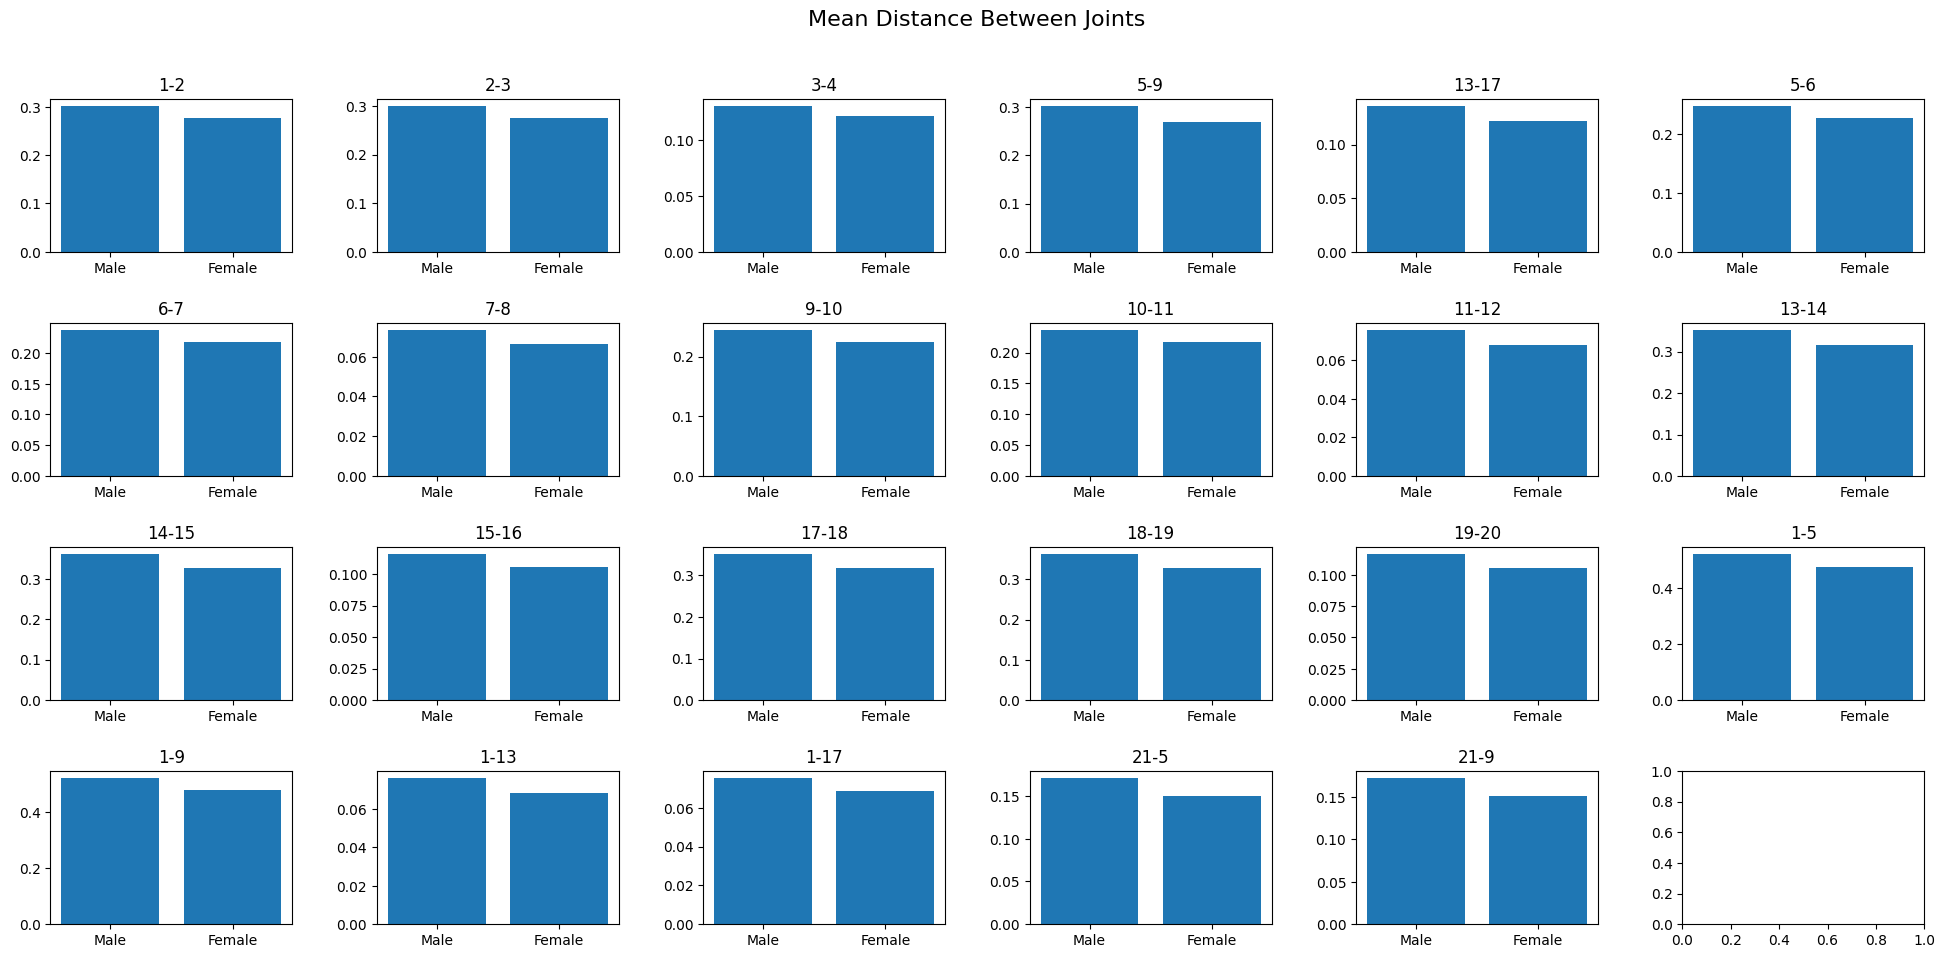

In [18]:
# Plot the differences
fig, ax = plt.subplots(4, 6, figsize=(20,10))
fig.suptitle('Mean Distance Between Joints', fontsize=16)
fig.tight_layout(pad=3.0)

for i, con in enumerate(m_mean.index):
    # Display bar chart for each connection for male and female
    ax[math.floor(i/6)][i%6].bar(['Male', 'Female'], [m_mean[con], f_mean[con]], align='center')
    ax[math.floor(i/6)][i%6].set_xticks([0,1])

    # Set title
    ax[math.floor(i/6)][i%6].set_title(con)

plt.show()

In [19]:
# Save data to CSV
m_mean.to_csv('Male Mean.csv')
f_mean.to_csv('Female Mean.csv')

## T-Test for Gender Differences

In [20]:
# Verify that the dataframes exist
try:
    male_stats.head()
except NameError:
    print('Run the section above this one first!')

In [21]:
from scipy.stats import ttest_ind

scores = {}

# Perform t-test on each connection
print('Con\t Independent\t\t Welch')
for con in male_stats:
    # To Store t test stat/p-values
    scores[con] = {}

    # Calculate t-test using independent and welch methods
    ind_stat, ind_p = ttest_ind(male_stats[con], female_stats[con])
    welch_stat, welch_p = ttest_ind(male_stats[con], female_stats[con], equal_var=False)

    # Print results
    print(f'{con}\t {ind_p}\t {welch_p}')

    # Store results
    scores[con]['ind_p'] = ind_p
    scores[con]['ind_stat'] = ind_stat
    scores[con]['welch_p'] = welch_p
    scores[con]['welch_stat'] = welch_stat
    
# Print significant results (p < 0.05)
sig_cons = []
for con in scores:
    if scores[con]['ind_p'] < 0.05 and scores[con]['welch_p'] < 0.05:
        print(f'Significant difference found for {con} using both t-tests')
        sig_cons.append(con)
    elif scores[con]['ind_p'] < 0.05:
        print(f'Significant difference found for {con} using independent t-test')
        sig_cons.append(con)
    elif scores[con]['welch_p'] < 0.05:
        print(f'Significant difference found for {con} using welch t-test')
        sig_cons.append(con)

sig_cons

Con	 Independent		 Welch
1-2	 7.140399863214291e-12	 2.023290519544718e-09
2-3	 8.035588306366944e-13	 1.0740872827171244e-09
3-4	 1.4716352620074524e-09	 2.2334564089577829e-10
5-9	 6.052862590580122e-19	 8.7552538674295e-20
13-17	 1.5980223078617235e-25	 1.7412695982957636e-22
5-6	 4.332954708684399e-18	 3.061590568790771e-14
6-7	 3.5333123613746897e-19	 7.095176110084313e-16
7-8	 1.6316320512694648e-11	 1.2848648596269665e-12
9-10	 1.744424988076988e-18	 6.765662349394278e-16
10-11	 7.570709550103827e-20	 4.813382437684829e-16
11-12	 4.612774956778405e-13	 2.2164504675015675e-12
13-14	 9.827177368567034e-12	 2.4199736336719702e-11
14-15	 5.012453552815964e-10	 2.074226093159609e-08
15-16	 1.8225680897042312e-12	 2.2177627310686765e-13
17-18	 1.8968124650414955e-11	 1.3363794057466671e-11
18-19	 1.6193781038128298e-10	 3.7356509786128366e-09
19-20	 4.863799655902991e-12	 3.632036811613149e-13
1-5	 4.446957404119548e-14	 4.1413012577449684e-10
1-9	 7.385812872895381e-14	 7.80002266130

['1-2',
 '2-3',
 '3-4',
 '5-9',
 '13-17',
 '5-6',
 '6-7',
 '7-8',
 '9-10',
 '10-11',
 '11-12',
 '13-14',
 '14-15',
 '15-16',
 '17-18',
 '18-19',
 '19-20',
 '1-5',
 '1-9',
 '1-13',
 '1-17',
 '21-5',
 '21-9']

In [22]:
# Export scores to CSV
scores_df = pd.DataFrame.from_dict(scores, orient='index')
scores_df.to_csv('T-Test Scores.csv')

In [23]:
# Free up memory
del male_stats
del female_stats
del df

## Standard Deviation for Each Joint for Each Actor

In [24]:
# Refresh Stats
stats = load_stats()

In [25]:
# Calculate the standard deviation for each connection
for p in stats:
    for con in stats[p]:
        stats[p][con] = np.std(stats[p][con])

In [26]:
# Convert to DataFrame
df = pd.DataFrame.from_dict(stats, orient='index')

# Average Standard Deviation for each connection
JointWise_std = df.mean(axis=0)

# Average Standard Deviation for each actor
ActorWise_std = df.mean(axis=1)

del stats # Free up memory

In [27]:
ActorWise_std.to_csv('ActorWise_std.csv')
JointWise_std.to_csv('JointWise_std.csv')

## Global Standard Deviation

In [7]:
# Refresh Stats
stats = load_stats()

In [9]:
# Try to load distances
try:
    with open('distances.pickle', 'rb') as handle:
        distances = pickle.load(handle)
        print('Distances loaded')
except FileNotFoundError:
    # Put all distances into one array
    distances = np.array([])
    print('Gathering distances...')
    for p in tqdm(stats, position=0, desc='Actor'):
        for con in tqdm(stats[p], position=1, desc='Connection', leave=False):
            d = np.array(stats[p][con])
            distances = np.concatenate((distances, d))

    # Pickle distances
    with open('global_distances.pickle', 'wb') as handle:
        pickle.dump(distances, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Distances saved')
        
del stats # Free up memory

Gathering distances...


Actor: 100%|██████████| 106/106 [08:15<00:00,  4.67s/it]


In [10]:
# Calculate standard deviation of all distances
Global_std = np.std(distances)
Global_std

0.13549542053389732